In [1]:
pip install pynrrd matplotlib SimpleITK scikit-image

  Obtaining dependency information for pynrrd from https://files.pythonhosted.org/packages/ee/43/1be50fe04e6a5df8cfdafa62151035a9358a768e26a5b9f33fc417e10bc6/pynrrd-1.0.0-py2.py3-none-any.whl.metadata
  Using cached pynrrd-1.0.0-py2.py3-none-any.whl.metadata (3.9 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8d/07/7e245ce1d7daec77cb1ca3b8caf094afb04c4c552a904787a1d684a2b606/matplotlib-3.8.3-cp311-cp311-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for SimpleITK from https://files.pythonhosted.org/packages/af/3a/bb0f2e759f288c89923f9cf099daf81a1350af3035fd992288943ac49709/SimpleITK-2.3.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/9f/d9/dc99e527d1a0050f0353d2fff3548273b4df6151884806e324f26572fd6b/scikit_image-0.22.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.11.1 from h

First take a glance at a single image in training.

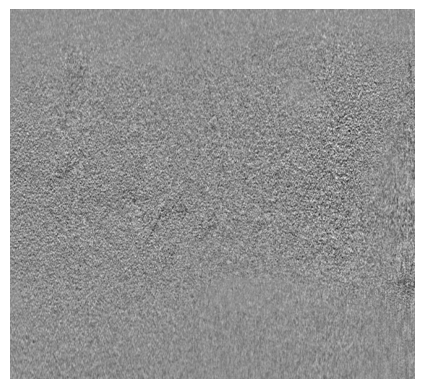

In [2]:
import nrrd
import matplotlib.pyplot as plt
import numpy as np

#Load the NRRD file
data, header = nrrd.read('./scans/L067_noise.nrrd')

# Check if the data is 3D or 2D to adjust visualization
if data.ndim == 3:
    slice_index = data.shape[0] // 2
    plt.imshow(data[slice_index], cmap='gray')
elif data.ndim == 2:
    plt.imshow(data, cmap='gray')

plt.axis('off')
plt.show()


In [3]:
import os
import SimpleITK as sitk
import numpy as np
import skimage.transform
from skimage.util import random_noise
import random
import glob
from scipy.ndimage import rotate, shift

In [4]:
def read_nrrd(file_path):
    """Reads a NRRD file and returns a numpy array."""
    sitk_image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(sitk_image)
    return array

def save_nrrd(array, file_path):
    sitk_image = sitk.GetImageFromArray(array)
    sitk.WriteImage(sitk_image, file_path)

def augment_image(ct_array):
    # Random rotation within +/- 20 degrees along a random axis
    axes = np.random.choice(range(ct_array.ndim), size=2, replace=False)
    angle = np.random.uniform(-20, 20)
    ct_rotated = rotate(ct_array, angle, axes=axes, reshape=False, mode='nearest')

    # flip along a random axis with a probability 0.5
    if np.random.rand() > 0.5:
        axis = np.random.choice(ct_array.ndim)
        ct_rotated = np.flip(ct_rotated, axis=axis)
    
    # Random translation within +/- 10 pixels for each axis
    shift_values = np.random.uniform(-10, 10, ct_array.ndim)
    ct_translated = shift(ct_rotated, shift=shift_values, mode='nearest')
    
    # Intensity adjustment by a random factor between 0.9 and 1.1
    intensity_factor = np.random.uniform(0.9, 1.1)
    ct_intensity_adjusted = ct_translated * intensity_factor
    # Keep the values within the original range
    ct_intensity_adjusted = np.clip(ct_intensity_adjusted, ct_array.min(), ct_array.max())
    
    return ct_intensity_adjusted

In [16]:
# Example usage
#ct_signal_path = 'L067_signal.nrrd'
#ct_noise_path = 'L067_noise.nrrd'

#ct_signal = read_nrrd(ct_signal_path)
#ct_noise = read_nrrd(ct_noise_path)

#aug_ct_signal, aug_ct_noise = augment_image(ct_signal, ct_noise)

In [17]:

source_folder = './scans'
target_folder = './aug_scans'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

signal_files = glob.glob(os.path.join(source_folder, '*_signal.nrrd'))
noise_files = glob.glob(os.path.join(source_folder, '*_noise.nrrd'))

for signal_file, noise_file in zip(signal_files, noise_files):
    # Read the images
    signal_image = sitk.ReadImage(signal_file)
    noise_image = sitk.ReadImage(noise_file)
    
    signal_array = sitk.GetArrayFromImage(signal_image)
    noise_array = sitk.GetArrayFromImage(noise_image)
    
    # Augment the images
    aug_signal_array = augment_image(signal_array)
    aug_noise_array = augment_image(noise_array)
    
    # Define new file names
    subject_id = os.path.basename(signal_file).split('_')[0]
    aug_signal_path = os.path.join(target_folder, f"{subject_id}_augmented_signal.nrrd")
    aug_noise_path = os.path.join(target_folder, f"{subject_id}_augmented_noise.nrrd")
    
    # Save the augmented images
    save_nrrd(aug_signal_array, aug_signal_path)
    save_nrrd(aug_noise_array, aug_noise_path)

print("Augmentation completed and files are saved in:", target_folder)

Augmentation completed and files are saved in: /Users/maggie-z/Desktop/Github/MedIMG/aug_scans
